In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device(device_name)

Found GPU at: /device:GPU:0


In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Lambda
from keras.models import Model

In [34]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [82]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [83]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [85]:
encoder = Model(inputs, z, name='encoder')

# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

In [86]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 64)           50240       input_3[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 2)            130         dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 2)            130         dense_14[0][0]                   
____________________________________________________________________________________________

In [87]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_20 (Dense)             (None, 784)               50960     
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [88]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 50500     
_________________________________________________________________
decoder (Functional)         (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


In [89]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [90]:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 188.8857 - val_loss: 168.7177
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 165.7380 - val_loss: 163.3124
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 162.2095 - val_loss: 161.1289
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 160.0625 - val_loss: 159.3068
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 158.5072 - val_loss: 157.9779
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 157.3195 - val_loss: 156.8564
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 156.3529 - val_loss: 156.2722
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.5730 - val_loss: 155.6045
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 154.9151 - val_loss: 155.0757
Epoch 10/100
1875/1875 [=============

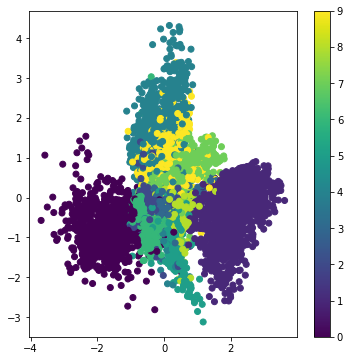

In [92]:
x_test_encoded = np.array(encoder.predict(x_test, batch_size=batch_size))
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

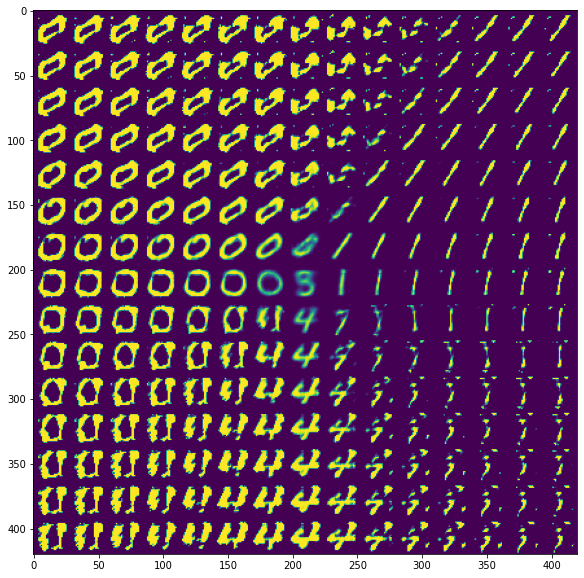

In [93]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()